In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
import re
from scipy.optimize import curve_fit
from matplotlib.gridspec import GridSpec
import os

## 1. Algoritmo de Metropolis - Hastings

Se propone generar $N$ muestras a una temperatura $T$ fija; para ello, en cada iteración $i \in [0, N]$:

1. Se inicializa un microestado aleatorio invocando la clase `microstate`.
2. Se calcula la energía del microestado y la magnetización del mismo con los métodos `calc_E()` y `calc_M()` respectivamente.
3. Se hace un "flip" (volteo) de un espín del arreglo aleatoriamente; esto se logra con el método `flip(int index)`, donde el índice es un número entero aleatorio $\in [0, L*L - 1]$.
4. Se calcula la nueva energía y magnetización del microestado, pero no usando los métodos anteriores: la actualización se realiza de forma eficiente calculando solamente la contribución de los vecinos más cercanos al espín que ha sido cambiado.
5. Se aplica la regla de aceptación:

```c++
deltaE <= 0 || probability_distribution(gen) < std::exp(-beta * deltaE)
```

Este paso es el corazón del método:
    * Si el cambio de energía al invertir un espín es negativo, significa que se encontró un estado de menor energía y, por lo tanto, se  acepta la transición.
    * En caso contrario, se genera un número aleatorio uniformemente distribuido $p$ en el intervalo $[0,1]$ y se compara con la probabilidad relativa de transición definida como: $P[\delta E] = e^{-\beta \Delta E}$, si $p < P[\delta E]$ la transicion es aceptada, en caso contrario es rechazada

6. Por último, se guardan los datos del microestado actual de la iteración y se imprimen en tiempo real hacia un archivo `.txt.`

Cabe resaltar que el algoritmo anterior se implementa en dos etapas:

* Burn-in: primero se ejecuta el algoritmo sin guardar la información de los microestados; de esta forma se garantiza que el sistema alcance un equilibrio térmico antes de empezar a muestrear los estados propiamente dichos. Esto permite una exploración más eficiente del espacio muestral.

* Muestreo: una vez alcanzado el equilibrio térmico, se comienzan a muestrear los microestados; estos se guardan cada 100
pasos para evitar que estén correlacionados.

In [7]:
def extract_L_and_temperature(filename):
    match = re.search(r'Ising(\d+)_T(\d+\.\d+)_Samples\.txt', filename)
    if match:
        L = int(match.group(1))
        temperature = float(match.group(2))
        return L, temperature
    return None, None

In [8]:
# Funcion gaussiana para ajuste
def gaussian(x, mean, amplitude, stddev):
    return amplitude * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2))

In [ ]:
# Extracción de datos de los archivos generados con Montecarlo
L = 10

file_pattern = f"../Ising{L}_T*_Samples.txt"
files = glob(file_pattern)

if not files:
    print(f"No se encontraron archivos coincidentes con: {file_pattern}")
    print("Directorio actual:", os.getcwd())
    print("Archivos en directorio superior:", os.listdir(".."))
    exit(1)

# Extraer L y temperaturas y ordenar archivos
L_temp_files = []
for file in files:
    file_L, temp = extract_L_and_temperature(file)
    if file_L is not None and temp is not None and file_L == L:
        L_temp_files.append((temp, file))

# Verificar si se encontraron archivos validos
if not L_temp_files:
    print(f"No se encontraron archivos válidos para L = {L}")
    print("Asegúrate de que los nombres de archivo sigan el formato: IsingL_Tt_Samples.txt")
    exit(1)

# Ordenar por temperatura
L_temp_files.sort(key=lambda x: x[0])
temperatures = [t[0] for t in L_temp_files]
files_sorted = [t[1] for t in L_temp_files]

print(f"Encontrados {len(temperatures)} archivos para L = {L} con temperaturas: {temperatures}")

Encontrados 8 archivos para L = 10 con temperaturas: [0.1, 0.5, 1.0, 1.5, 2.5, 3.0, 3.5, 4.0]


Procesando archivo: ../Ising10_T0.100000_Samples.txt, T = 0.1
T = 0.1: 5000 muestras, E_range = [-160.0, -160.0], M_range = [0.0, 0.0]
No hay suficientes puntos para ajustar gaussiana para T=0.1
Procesando archivo: ../Ising10_T0.500000_Samples.txt, T = 0.5
T = 0.5: 5000 muestras, E_range = [-200.0, -200.0], M_range = [-100.0, -100.0]
No hay suficientes puntos para ajustar gaussiana para T=0.5
Procesando archivo: ../Ising10_T1.000000_Samples.txt, T = 1.0
T = 1.0: 5000 muestras, E_range = [-200.0, -180.0], M_range = [-100.0, -94.0]
Procesando archivo: ../Ising10_T1.500000_Samples.txt, T = 1.5
T = 1.5: 5000 muestras, E_range = [-200.0, -148.0], M_range = [74.0, 100.0]
Procesando archivo: ../Ising10_T2.500000_Samples.txt, T = 2.5
T = 2.5: 5000 muestras, E_range = [-200.0, -40.0], M_range = [-100.0, 100.0]
Procesando archivo: ../Ising10_T3.000000_Samples.txt, T = 3.0
T = 3.0: 5000 muestras, E_range = [-160.0, -20.0], M_range = [-86.0, 88.0]
Procesando archivo: ../Ising10_T3.500000_Samples.t

/tmp/ipykernel_34432/4130514749.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


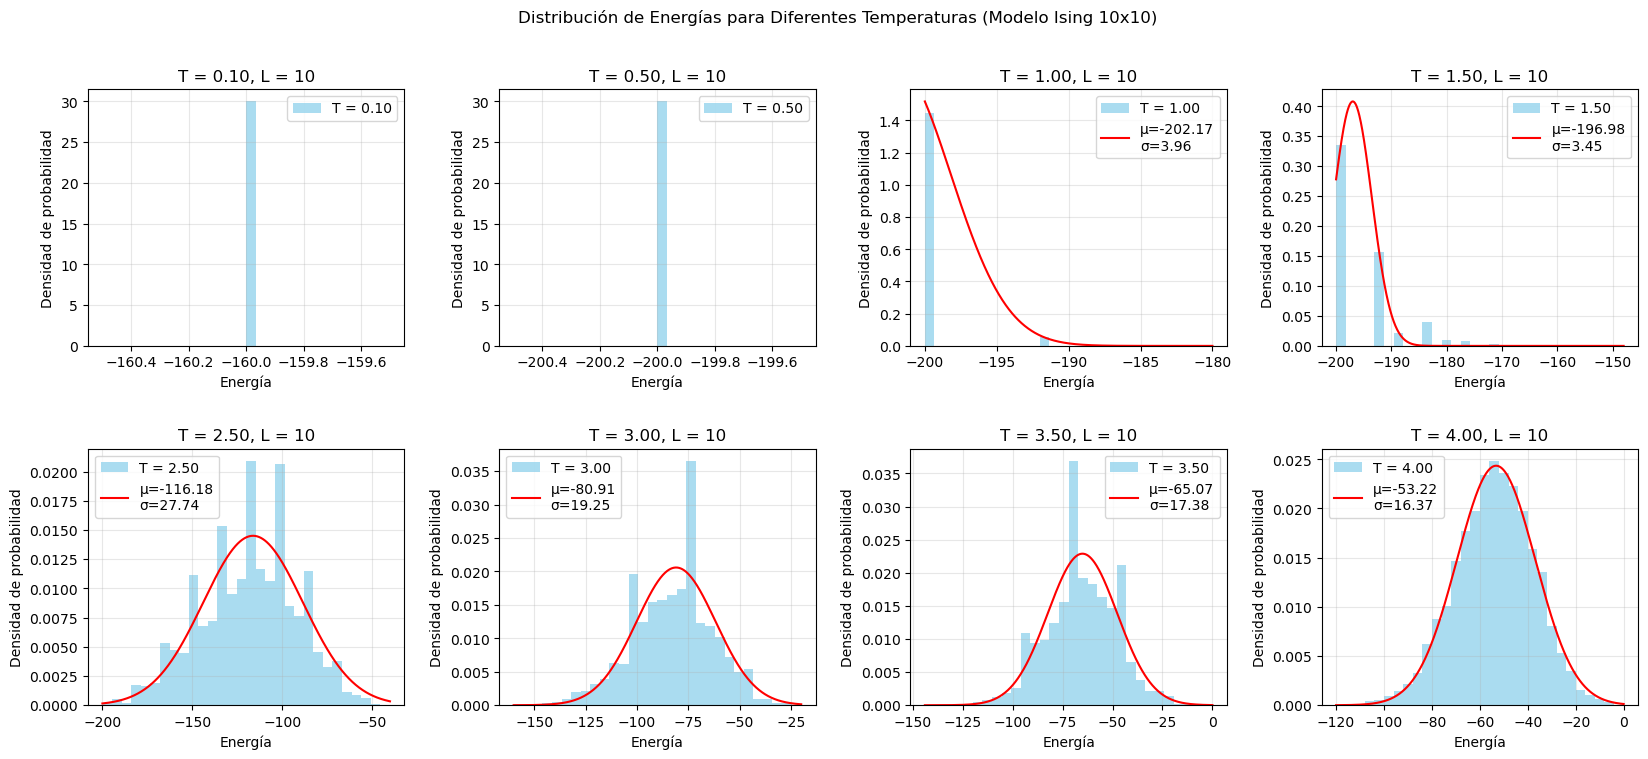

/tmp/ipykernel_34432/4130514749.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


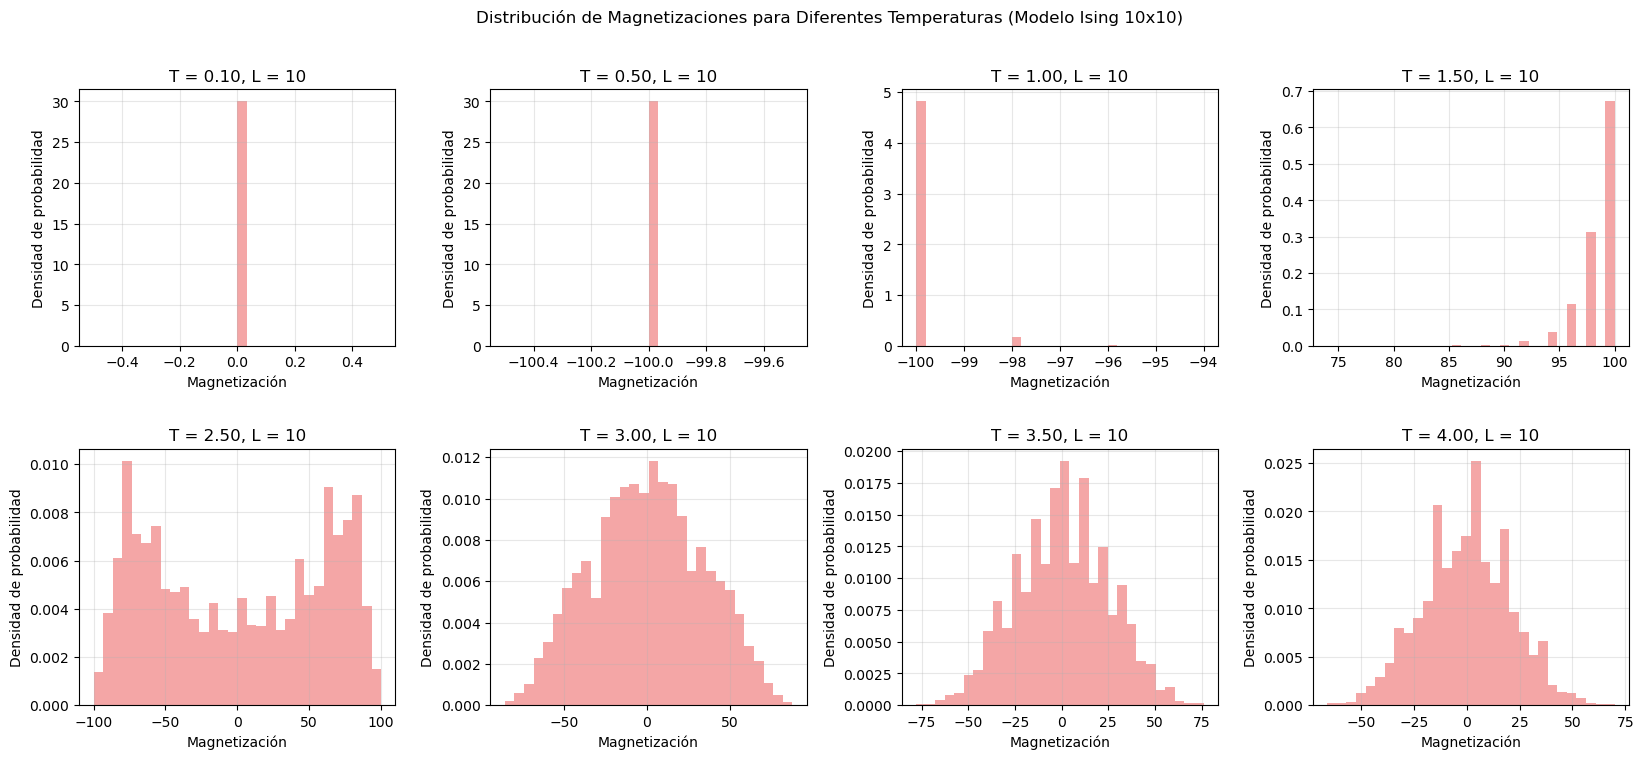

In [10]:
# Plot principal
n_temps = len(temperatures)
if n_temps == 0:
    print("No hay temperaturas para graficar.")
    exit(1)

n_cols = min(4, n_temps)
n_rows = (n_temps + n_cols - 1) // n_cols

fig = plt.figure(figsize=(5*n_cols, 4*n_rows))
gs = GridSpec(n_rows, n_cols, hspace=0.4, wspace=0.3)

# Procesar cada archivo
for idx, (temp, file_path) in enumerate(zip(temperatures, files_sorted)):
    print(f"Procesando archivo: {file_path}, T = {temp}")
    
    # Leer datos
    data = []
    with open(file_path, 'r') as f:
        for line_num, line in enumerate(f):
            parts = line.strip().split()
            if len(parts) >= 3:
                try:
                    # Los últimos dos valores son energía y magnetización
                    energy = float(parts[-2])
                    magnetization = float(parts[-1])
                    data.append((energy, magnetization))
                except ValueError as e:
                    print(f"Error en línea {line_num}: {e}")
                    continue
    
    if not data:
        print(f"Advertencia: No se encontraron datos válidos en {file_path}")
        continue
    
    # Convertir a arrays de numpy
    energies = np.array([d[0] for d in data])
    magnetizations = np.array([d[1] for d in data])
    
    print(f"T = {temp}: {len(energies)} muestras, E_range = [{energies.min()}, {energies.max()}], M_range = [{magnetizations.min()}, {magnetizations.max()}]")
    
    # Crear subplot
    row = idx // n_cols
    col = idx % n_cols
    ax = fig.add_subplot(gs[row, col])
    
    # Histograma de energía
    counts, bins, patches = ax.hist(energies, bins=30, alpha=0.7, 
                                   color='skyblue', density=True, 
                                   label=f'T = {temp:.2f}')
    
    # Ajuste gaussiano
    try:
        bin_centers = (bins[:-1] + bins[1:]) / 2
        # Filtrar bins con conteo cero para evitar problemas en el ajuste
        mask = counts > 0
        if np.sum(mask) > 3:  # Necesitamos al menos 3 puntos para el ajuste
            popt, _ = curve_fit(gaussian, bin_centers[mask], counts[mask], 
                               p0=[np.mean(energies), np.max(counts), np.std(energies)])
            
            # Graficar ajuste
            x_fit = np.linspace(bins[0], bins[-1], 1000)
            ax.plot(x_fit, gaussian(x_fit, *popt), 'r-', 
                    label=f'μ={popt[0]:.2f}\nσ={popt[2]:.2f}')
        else:
            print(f"No hay suficientes puntos para ajustar gaussiana para T={temp}")
    except Exception as e:
        print(f"No se pudo ajustar gaussiana para T={temp}: {e}")
    
    ax.set_title(f'T = {temp:.2f}, L = {L}')
    ax.set_xlabel('Energía')
    ax.set_ylabel('Densidad de probabilidad')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle(f'Distribución de Energías para Diferentes Temperaturas (Modelo Ising {L}x{L})')
plt.tight_layout()
plt.savefig(f'ising_energy_distributions_L{L}.png', dpi=300, bbox_inches='tight')
plt.show()

# Figura para magnetizaciones
fig2 = plt.figure(figsize=(5*n_cols, 4*n_rows))
gs2 = GridSpec(n_rows, n_cols, hspace=0.4, wspace=0.3)

for idx, (temp, file_path) in enumerate(zip(temperatures, files_sorted)):
    # Leer datos
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 3:
                try:
                    magnetization = float(parts[-1])
                    data.append(magnetization)
                except ValueError:
                    continue
    
    if not data:
        continue
        
    magnetizations = np.array(data)
    
    # Crear subplot
    row = idx // n_cols
    col = idx % n_cols
    ax = fig2.add_subplot(gs2[row, col])
    
    # Histograma de magnetización
    ax.hist(magnetizations, bins=30, alpha=0.7, color='lightcoral', density=True)
    
    ax.set_title(f'T = {temp:.2f}, L = {L}')
    ax.set_xlabel('Magnetización')
    ax.set_ylabel('Densidad de probabilidad')
    ax.grid(True, alpha=0.3)

plt.suptitle(f'Distribución de Magnetizaciones para Diferentes Temperaturas (Modelo Ising {L}x{L})')
plt.tight_layout()
plt.savefig(f'ising_magnetization_distributions_L{L}.png', dpi=300, bbox_inches='tight')
plt.show()